# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24, RF = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1, RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        # x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [22]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]             720
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [24]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17653755843639374 Batch_id=468 Accuracy=89.78: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.12726078927516937 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.03481252118945122 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.0348653644323349 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.14632119238376617 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.04614589735865593 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.004484623670578003 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.04626606032252312 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.08621899038553238 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.019743075594305992 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.05629169940948486 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 38.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.019561946392059326 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.03476926311850548 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.037427809089422226 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.06698363274335861 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]



Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

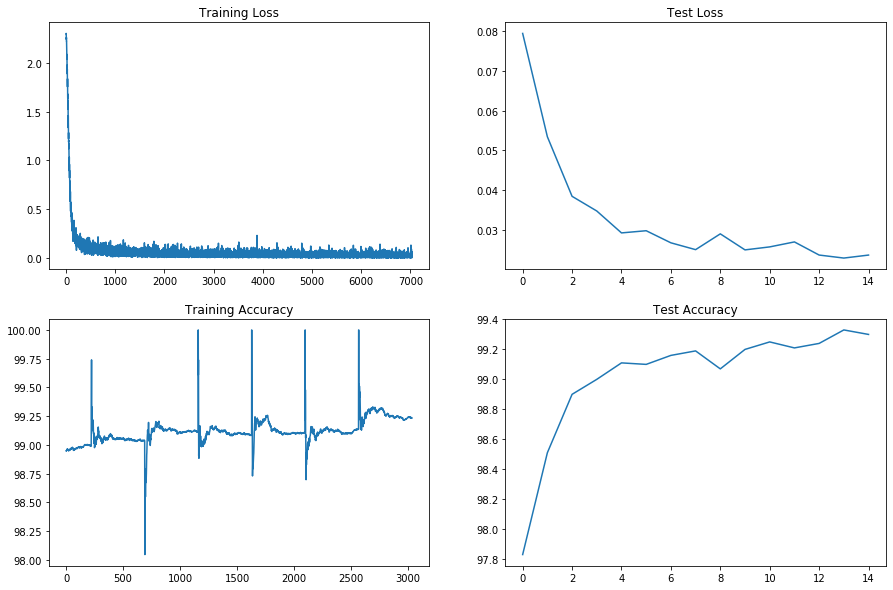

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
'''
Target : 99.4 in less then 15 epochs with less then 8k parameters
Analysis : Achieved 99.33% accuracy in 13th epoch with 7.7K parameters. Accuracy might be decreased due to less number of parameters.
'''
